In [77]:
import pandas as pd
import numpy as np
from feature_engine.creation import CyclicalFeatures
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from lime import lime_tabular
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import plotly.express as px
from xgboost import XGBClassifier
import shap
import pickle
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
warnings. filterwarnings('ignore')
random.seed(42)
np.random.seed(42)

In [74]:
df = pd.read_csv('new dataset.csv', parse_dates=['Timestamp'])
df = df.drop('Country', axis=1)

df['Hour'] = df['Timestamp'].dt.hour
cyclic = CyclicalFeatures(variables=None, drop_original=True)
conv = cyclic.fit_transform(df[['Hour']])
df = pd.concat([df, conv], axis=1)

df['Weekend'] = df['Timestamp'].apply(lambda x: x.weekday() >= 5)
df['Weekend'] = df['Weekend'].astype(int)

random_integers = [random.randint(0, 1) for _ in range(len(df))]
df['Introvert'] = random_integers

random_notif = [random.randint(0, 3) for _ in range(len(df))]
df['Ad Location'] = random_notif
replace_notif = {0: 'Push Notif', 1: 'Pop Up', 2: 'Lower Banner', 3: 'Upper Banner'}

df['Ad Location'] = df['Ad Location'].replace(replace_notif)
df['Ad Category'] = None
df['Ad Category'].iloc[df[(df['Age'] >= 40)].index] = 'Finance'                     
df['Ad Category'].iloc[df[(df['Age'] >= 19) & (df['Age'] <= 40) & (df['Male'] == 0) & (df['Introvert'] == 0)].index] = 'Fashion'
df['Ad Category'].iloc[df[(df['Age'] >= 19) & (df['Age'] <= 30) & (df['Male'] == 1) & (df['Introvert'] == 1)].index] = 'Games'
df['Ad Category'].iloc[df[(df['Age'] >= 40)].index] = 'Finance'
df['Ad Category'].iloc[df[(df['Age'] >= 19) & (df['Age'] <= 35) & (df['Hour'] > 12) & (df['Hour'] < 18)].index] = 'Food'
df['Ad Category'].iloc[df[(df['Age'] >= 40) & (df['Age'] <= 50) & (df['Weekend'] == 1) & (df['Area Income'] > df['Area Income'].quantile(0.50))].index] = 'Travel'

choices = ['Finance', 'Fashion', 'Food', 'Games', 'Travel']
probs = [0.45, 0.25, 0.15, 0.08, 0.07]
for i in df[df['Ad Category'].isna()].index:
    df.at[i, 'Ad Category'] = random.choices(choices, probs)[0]

In [75]:
X = df.drop(['Timestamp', 'Clicked on Ad', 'Hour'], axis=1)
X = pd.get_dummies(X, dtype='int')
y = df[['Clicked on Ad']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
df_dashboard = df.iloc[X_train.index]
df_dashboard[['Timestamp', 'Age', 'Male', 'Introvert', 'Continent',  'Area Income', 'Daily Internet Usage', 'Daily Time Spent on Site',
        'Ad Location', 'Ad Category', 'Clicked on Ad']].to_csv('df_dashboard.csv', index=False)

In [ ]:
#df[['Timestamp', 'Age', 'Male', 'Introvert', 'Continent',  'Area Income', 'Daily Internet Usage', 'Daily Time Spent on Site',
#        'Ad Location', 'Ad Category', 'Clicked on Ad']].to_csv('cleaned dataset.csv', index=False)

In [ ]:
df_predict = df.iloc[X_test.index]
df_predict[['Timestamp', 'Age', 'Male', 'Introvert', 'Continent',  'Area Income', 'Daily Internet Usage', 'Daily Time Spent on Site',
        'Ad Location', 'Ad Category']].to_csv('df_predict.csv', index=False)

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
pickle.dump(rfc, open('rfc.pkl', 'wb'))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

In [ ]:
explainer = shap.Explainer(rfc)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], features=X_train, alpha=0.5)

In [76]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test.values)
#pickle.dump(xgb, open('xgb.pkl', 'wb'))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       120
           1       0.95      0.95      0.95       130

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

[[114   6]
 [  6 124]]


In [86]:
preds_proba_1 = xgb.predict_proba(X_test.values)[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds_proba_1)
auc = roc_auc_score(y_test, preds_proba_1)

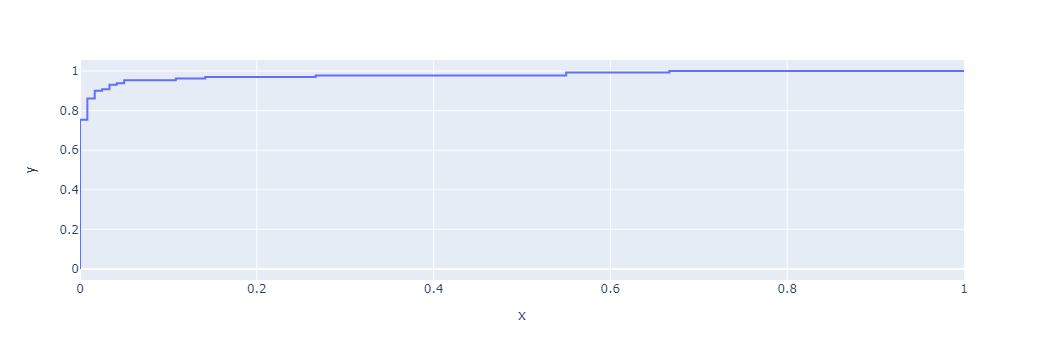

In [93]:
px.line(x=fpr, y=tpr)

In [ ]:
explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(X_train[pd.concat([X_train, y_train], axis=1)['Clicked on Ad'] == 1])
shap.summary_plot(shap_values, features=X_train[pd.concat([X_train, y_train], axis=1)['Clicked on Ad'] == 1], alpha=0.5)

In [ ]:
df_cluster = pd.concat([X_train, y_train], axis=1)
df_cluster_finance = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Finance'] == 1)].drop(['Clicked on Ad', 'Ad Category_Finance'], axis=1)
df_cluster_fashion = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Fashion'] == 1)].drop(['Clicked on Ad', 'Ad Category_Fashion'], axis=1)
df_cluster_food = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Food'] == 1)].drop(['Clicked on Ad', 'Ad Category_Food'], axis=1)
df_cluster_games = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Games'] == 1)].drop(['Clicked on Ad', 'Ad Category_Games'], axis=1)
df_cluster_travel = df_cluster[(df_cluster['Clicked on Ad'] == 1) & (df_cluster['Ad Category_Travel'] == 1)].drop(['Clicked on Ad', 'Ad Category_Travel'], axis=1)

In [ ]:
scaler_finance = MinMaxScaler()
k = kelbow_visualizer(KMeans(), scaler.fit_transform(df_cluster_finance), k=(2,10)).elbow_value_
kmeans_finance = KMeans(n_clusters=k)
kmeans_finance.fit(scaler.fit_transform(df_cluster_finance))

In [ ]:
kmeans_finance.labels_

In [ ]:
scaler_fashion = MinMaxScaler()
k = kelbow_visualizer(KMeans(), scaler.fit_transform(df_cluster_fashion), k=(2,10)).elbow_value_
kmeans_fashion = KMeans(n_clusters=k)
kmeans_fashion.fit(scaler.fit_transform(df_cluster_fashion))

In [ ]:
scaler_food = MinMaxScaler()
k = kelbow_visualizer(KMeans(), scaler.fit_transform(df_cluster_food), k=(2,10)).elbow_value_
kmeans_food = KMeans(n_clusters=k)
kmeans_food.fit(scaler.fit_transform(df_cluster_food))

In [ ]:
scaler_games = MinMaxScaler()
k = kelbow_visualizer(KMeans(), scaler.fit_transform(df_cluster_games), k=(2,10)).elbow_value_
kmeans_games = KMeans(n_clusters=k)
kmeans_games.fit(scaler.fit_transform(df_cluster_games))

In [ ]:
pickle.dump(scaler_finance, open('scaler_finance.pkl', 'wb'))
pickle.dump(kmeans_finance, open('kmeans_finance.pkl', 'wb'))
pickle.dump(scaler_fashion, open('scaler_fashion.pkl', 'wb'))
pickle.dump(kmeans_fashion, open('kmeans_fashion.pkl', 'wb'))
pickle.dump(scaler_food, open('scaler_food.pkl', 'wb'))
pickle.dump(kmeans_food, open('kmeans_food.pkl', 'wb'))
pickle.dump(scaler_games, open('scaler_games.pkl', 'wb'))
pickle.dump(kmeans_games, open('kmeans_games.pkl', 'wb'))

In [ ]:
df_cluster_finance['cluster'] = kmeans_finance.labels_

In [ ]:
df_cluster_finance['cluster'].value_counts()

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

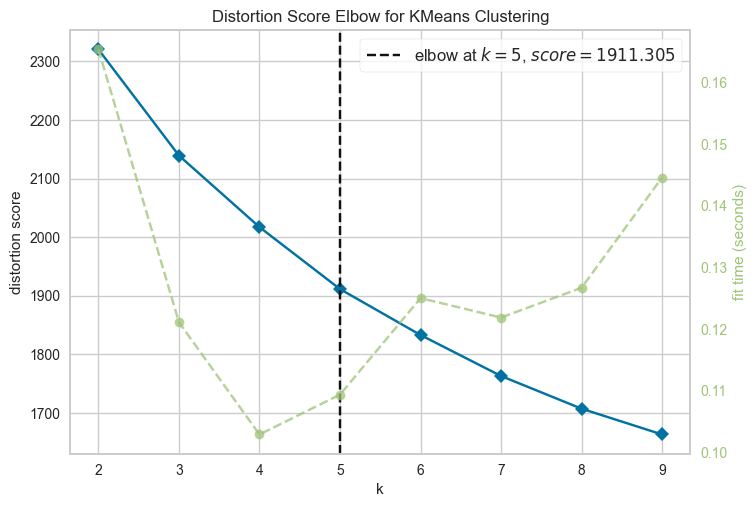

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9), k=(2, 10))

In [14]:
kelbow_visualizer(KMeans(), X_train_scaled, k=(2,10))

In [15]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=5)

In [29]:
X_train_cluster = X_train.copy()

In [30]:
X_train_cluster

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Hour_sin,Hour_cos,Weekend,Introvert,Continent_Africa,...,Continent_South America,Ad Location_Lower Banner,Ad Location_Pop Up,Ad Location_Push Notif,Ad Location_Upper Banner,Ad Category_Fashion,Ad Category_Finance,Ad Category_Food,Ad Category_Games,Ad Category_Travel
82,56.64,38,61652.53,115.91,0,-9.976688e-01,-0.068242,0,1,0,...,0,0,0,0,1,0,1,0,0,0
991,38.96,38,36497.22,140.67,1,-9.422609e-01,-0.334880,0,0,1,...,0,0,0,1,0,1,0,0,0,0
789,40.88,33,48554.45,136.18,1,-9.976688e-01,-0.068242,0,1,0,...,0,0,1,0,0,0,0,1,0,0
894,85.37,36,66262.59,194.56,1,-9.976688e-01,-0.068242,0,0,0,...,0,0,1,0,0,0,1,0,0,0
398,76.24,40,75524.78,198.32,1,-2.449294e-16,1.000000,0,1,1,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,72.23,25,46557.92,241.03,1,-9.976688e-01,-0.068242,0,1,0,...,0,0,0,1,0,0,0,1,0,0
270,44.49,53,63100.13,168.00,1,9.976688e-01,-0.068242,1,0,1,...,0,1,0,0,0,0,1,0,0,0
860,91.37,45,51920.49,182.65,1,9.422609e-01,-0.334880,0,1,0,...,0,1,0,0,0,0,1,0,0,0
435,56.66,42,72684.44,139.42,0,3.984011e-01,-0.917211,1,1,0,...,0,0,0,0,1,0,0,0,0,1


In [32]:
X_train_cluster['cluster'] = kmeans.labels_

In [34]:
X_train_cluster 

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Hour_sin,Hour_cos,Weekend,Introvert,Continent_Africa,...,Ad Location_Lower Banner,Ad Location_Pop Up,Ad Location_Push Notif,Ad Location_Upper Banner,Ad Category_Fashion,Ad Category_Finance,Ad Category_Food,Ad Category_Games,Ad Category_Travel,cluster
82,56.64,38,61652.53,115.91,0,-9.976688e-01,-0.068242,0,1,0,...,0,0,0,1,0,1,0,0,0,0
991,38.96,38,36497.22,140.67,1,-9.422609e-01,-0.334880,0,0,1,...,0,0,1,0,1,0,0,0,0,2
789,40.88,33,48554.45,136.18,1,-9.976688e-01,-0.068242,0,1,0,...,0,1,0,0,0,0,1,0,0,4
894,85.37,36,66262.59,194.56,1,-9.976688e-01,-0.068242,0,0,0,...,0,1,0,0,0,1,0,0,0,4
398,76.24,40,75524.78,198.32,1,-2.449294e-16,1.000000,0,1,1,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,72.23,25,46557.92,241.03,1,-9.976688e-01,-0.068242,0,1,0,...,0,0,1,0,0,0,1,0,0,2
270,44.49,53,63100.13,168.00,1,9.976688e-01,-0.068242,1,0,1,...,1,0,0,0,0,1,0,0,0,3
860,91.37,45,51920.49,182.65,1,9.422609e-01,-0.334880,0,1,0,...,1,0,0,0,0,1,0,0,0,3
435,56.66,42,72684.44,139.42,0,3.984011e-01,-0.917211,1,1,0,...,0,0,0,1,0,0,0,0,1,0


In [35]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [36]:
pickle.dump(kmeans, open('kmeans.pkl', 'wb'))

In [42]:
#X_train.to_csv('df_test_cluster.csv', index=False)

In [53]:
explainer = shap.KernelExplainer(kmeans.predict, X_train_scaled[0:100])
shap_values = explainer.shap_values(X_train_scaled[0:100])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


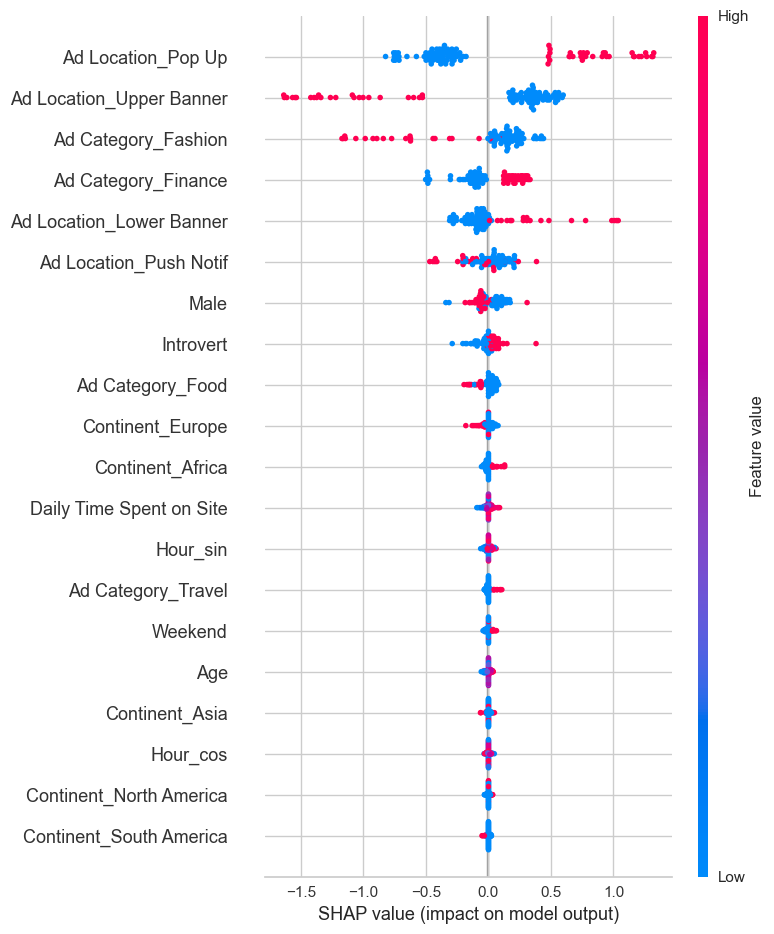

In [55]:
shap.summary_plot(shap_values, X_train_scaled[0:100], feature_names=X_train.columns)

In [68]:
data = shap.kmeans(X_train_scaled, 100)
explainer = shap.KernelExplainer(kmeans.predict, data)
shap_values = explainer.shap_values(X_train_scaled[0:100])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


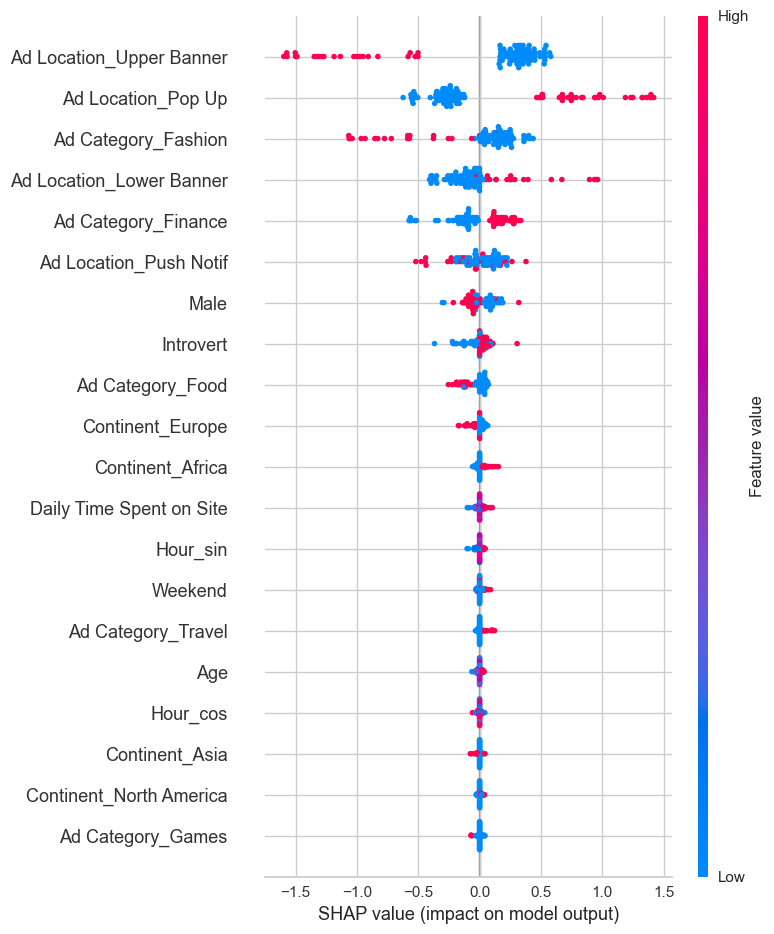

In [70]:
shap.summary_plot(shap_values, X_train_scaled[0:100], feature_names=X_train.columns)

In [71]:
dates = ['All', '2016 January', '2016 February']

In [72]:
dates.index('All')

0